In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

import mlflow
import mlflow.sklearn

In [2]:
credito = pd.read_csv('Credit.csv')
credito.shape

(1000, 21)

In [3]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
for col in credito.columns:
    if credito[col].dtype == 'object':
        credito[col] = credito[col].astype('category').cat.codes

In [5]:
credito.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [6]:
previsores = credito.iloc[:,0:20].values
classe = credito.iloc[:,20].values

In [7]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores,classe,
                                        test_size=0.3,random_state=123)

In [ ]:
def treina_rf(n_estimators):
    mlflow.set_experiment("creditFirstExperimentRandom")
    with mlflow.start_run(run_name=f"estimator:{n_estimators}"):
        
        modelorf = RandomForestClassifier(n_estimators=n_estimators)
        modelorf.fit(X_treinamento, y_treinamento)
        previsoes = modelorf.predict(X_teste)

        #log de hiper parametros
        mlflow.log_param("n_estimators", n_estimators)

        #métricas
        acuracia = accuracy_score(y_teste, previsoes)
        recall = recall_score(y_teste, previsoes)
        precision = precision_score(y_teste, previsoes)
        f1 = f1_score(y_teste, previsoes)
        auc= roc_auc_score(y_teste, previsoes)
        log = log_loss(y_teste, previsoes)

        #registrar métricas
        mlflow.log_metric("acuracia",acuracia)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("f1",f1)
        mlflow.log_metric("auc",auc)
        mlflow.log_metric("log",log)    

        #gráficos
        cm = confusion_matrix(y_teste, previsoes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.savefig("png/confusionrf.png")
        fpr, tpr, _ = roc_curve(y_teste, modelorf.predict_proba(X_teste)[:, 1])
        roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_disp.plot()
        plt.savefig("png/rocrf.png")
        
        #logar gráficos
        mlflow.log_artifact("png/confusionrf.png")
        mlflow.log_artifact("png/rocrf.png")   

        mlflow.sklearn.log_model(modelorf,"ModeloRf") #coloca o modelo la

        #informações da execução
        print("Modelo: ", mlflow.active_run().info.run_uuid)   

    mlflow.end_run()

2025/02/11 10:45:51 INFO mlflow.tracking.fluent: Experiment with name 'creditFirstExperimentRandom' does not exist. Creating a new experiment.
c:\Users\FFranci8\.virtualenvs\mflow-study-jnj-6ZsSCTUq\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
2025/02/11 10:46:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  35e006cc9c9d41699478e971661e54a3


c:\Users\FFranci8\.virtualenvs\mflow-study-jnj-6ZsSCTUq\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
2025/02/11 10:46:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  dd0d1d11aae7483c8e99a4820269d514


c:\Users\FFranci8\.virtualenvs\mflow-study-jnj-6ZsSCTUq\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
2025/02/11 10:47:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  2cdb48a6541e42b9a46001737a4e3bec


c:\Users\FFranci8\.virtualenvs\mflow-study-jnj-6ZsSCTUq\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
2025/02/11 10:47:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  b6032205712a407db2e7e9612bead132


c:\Users\FFranci8\.virtualenvs\mflow-study-jnj-6ZsSCTUq\lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
2025/02/11 10:48:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo:  305fe6af70bb4229a137d2a097e30594


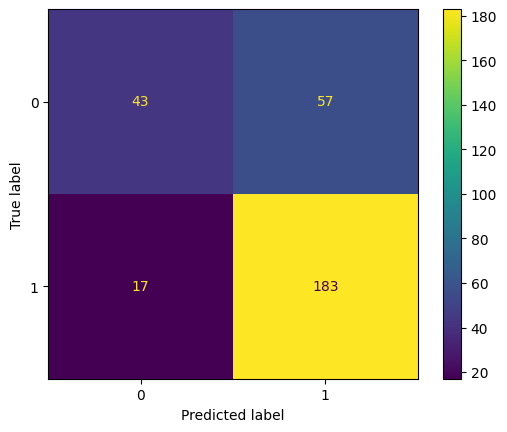

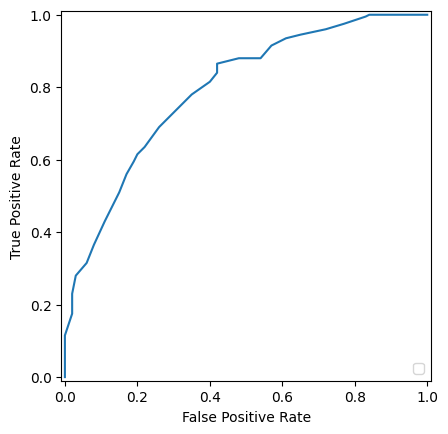

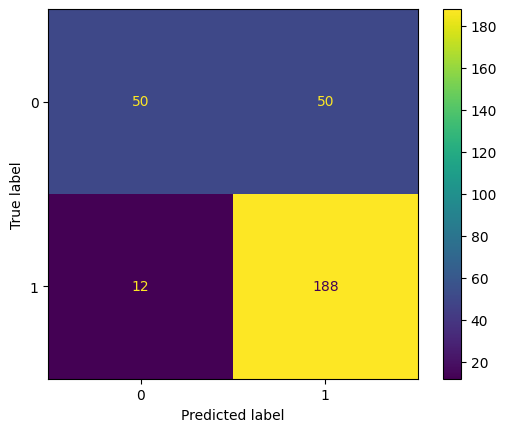

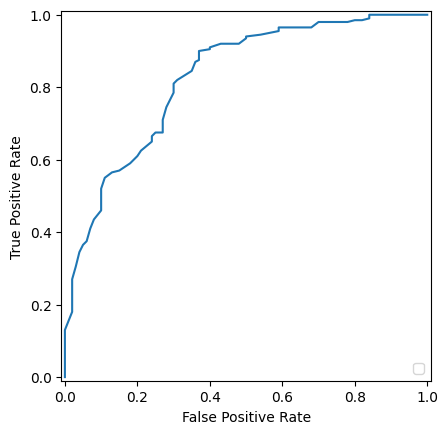

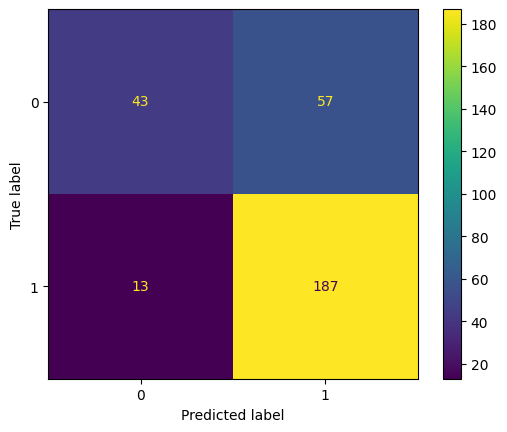

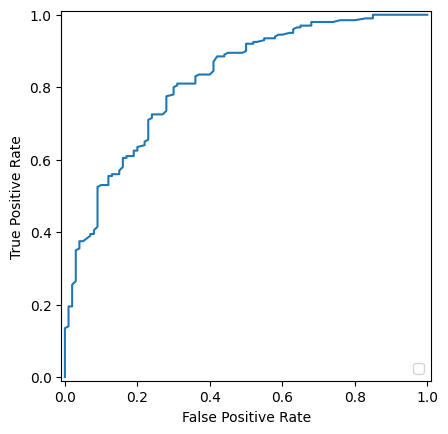

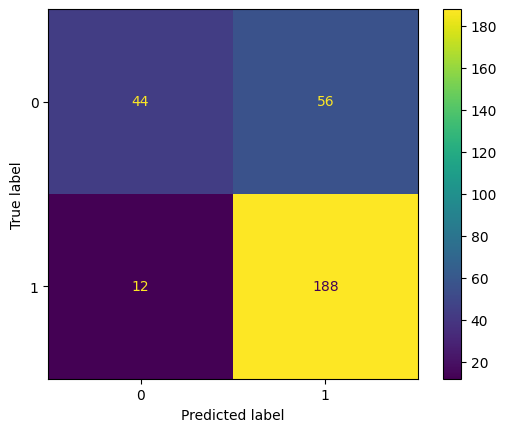

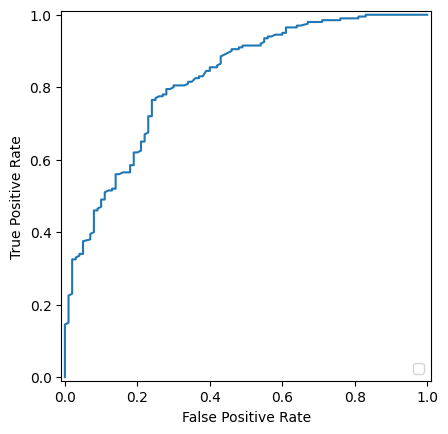

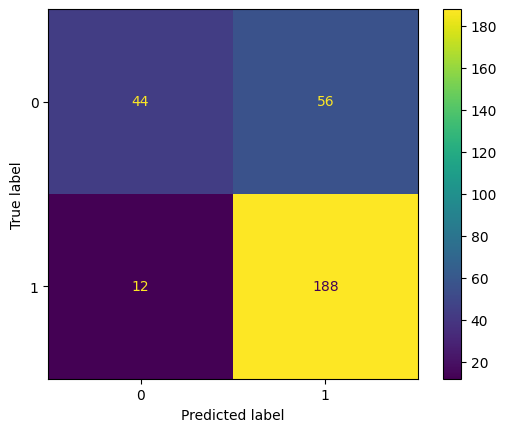

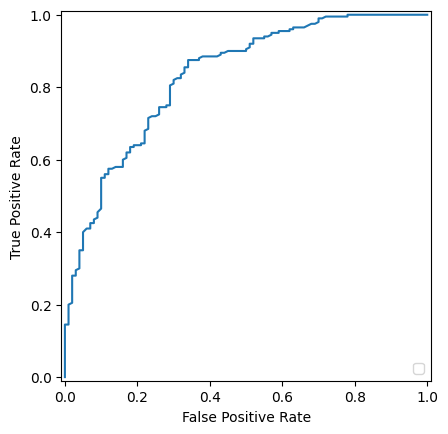

In [9]:
arvores = [50,100,500,750,1000]
for n in arvores:
    treina_rf(n)